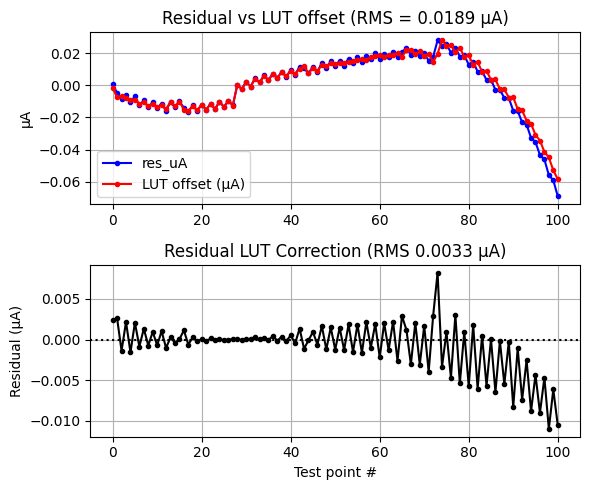

'\n\nprint(f"RMS before = {rms_before:.4f} µA")\nprint(f"RMS after  = {rms_after:.4f} µA   (×{improvement:.2f} improvement)")\nprint(f"✓ Reversed-index LUT saved to {lut_filename} ({ADC_SIZE} lines)")\nprint(f"✓ Saved ADC error vs LUT correction to {csv_output_name}")\n'

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# set parameters
csv_file = "samples_A_101p_uA.csv"
range_id = 2
ADC_BITS = 20
ADC_SIZE = 2**ADC_BITS
ADC_MID = ADC_SIZE // 2
N_POINT = 101
adc_span_uA = 200  # ±100 µA
gain_uA_per_cnt = adc_span_uA / ADC_SIZE

# load the data
df = pd.read_csv(csv_file, comment="#", header=None,
                 names=["i_src", "range_idx", "i_meas", "adc_val"],
                 skip_blank_lines=True)
sub = df[df["range_idx"] == range_id].reset_index(drop=True)
sub["adc_val"] = sub["adc_val"].astype(np.int64)

# -----------------------------
# 3) BASELINE FIT & RESIDUAL (µA)
# -----------------------------
p = np.polyfit(sub["i_src"], sub["i_meas"], 1)
y_fit = np.polyval(p, sub["i_src"])
res_uA = sub["i_meas"] - y_fit

# -----------------------------
# 4) INTERPOLATED LUT (µA)
# -----------------------------
edges = np.linspace(-ADC_MID, ADC_MID, N_POINT + 1)
center_signed = (edges[:-1] + edges[1:]) / 2

i_unique, idx_grp = np.unique(sub["i_src"], return_inverse=True)
mean_res_pt_uA = np.bincount(idx_grp, weights=res_uA) / np.bincount(idx_grp)
if len(mean_res_pt_uA) < N_POINT:
    mean_res_pt_uA = np.pad(mean_res_pt_uA, (0, N_POINT - len(mean_res_pt_uA)), 'constant')

adc_signed = np.arange(-ADC_MID, ADC_MID)
lut_uA = interp1d(center_signed, mean_res_pt_uA, kind='cubic', fill_value="extrapolate")(adc_signed)
lut_cnt_int16 = np.round(lut_uA / gain_uA_per_cnt).astype(np.int16)

# -----------------------------
# 5) APPLY LUT with REVERSED INDEX
# -----------------------------
idx_fwd = sub["adc_val"] + ADC_MID
idx_rev = ADC_SIZE - idx_fwd - 1
offset_cnt = lut_cnt_int16[idx_rev]
offset_uA = offset_cnt * gain_uA_per_cnt
res_corr_uA = res_uA - offset_uA

# -----------------------------
# 6) METRICS
# -----------------------------
rms_before = np.sqrt(np.mean(res_uA**2))
rms_after = np.sqrt(np.mean(res_corr_uA**2))
improvement = rms_before / rms_after

# -----------------------------
# 7) SAVE .mem FILE
# -----------------------------
lut_filename = f"lut_range{range_id}_20bit_int16_interp_rev.mem"
np.savetxt(lut_filename, lut_cnt_int16, fmt='%d')

# -----------------------------
# 8) SAVE ADC ERROR & LUT VALUES
# -----------------------------
adc_error_cnt = np.round(res_uA / gain_uA_per_cnt).astype(np.int32)
lut_used_cnt = offset_cnt.astype(np.int32)
tbl = pd.DataFrame({
    "i_src_uA": sub["i_src"],
    "ADC_Error_cnt": adc_error_cnt,
    "LUT_Corr_cnt": lut_used_cnt
})
csv_output_name = f"adcErr_lutCorr_range{range_id}_rev.csv"
tbl.to_csv(csv_output_name, index=False)

# -----------------------------
# 9) PLOTS
# -----------------------------
plt.figure(figsize=(6, 5))

plt.subplot(2, 1, 1)
plt.plot(res_uA, 'b.-', label='res_uA')
plt.plot(offset_uA, 'r.-', label='LUT offset (µA)')
plt.grid(True)
plt.ylabel('µA')
plt.legend()
plt.title(f'Residual vs LUT offset (RMS = {rms_before:.4f} µA)')

plt.subplot(2, 1, 2)
plt.plot(res_corr_uA, 'k.-')
plt.axhline(0, color='k', linestyle=':')
plt.xlabel('Test point #')
plt.ylabel('Residual (µA)')
plt.title(f'Residual LUT Correction (RMS {rms_after:.4f} µA)')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"RMS before = {rms_before:.4f} µA")
print(f"RMS after  = {rms_after:.4f} µA   (×{improvement:.2f} improvement)")
print(f"✓ Reversed-index LUT saved to {lut_filename} ({ADC_SIZE} lines)")
print(f"✓ Saved ADC error vs LUT correction to {csv_output_name}")

In [2]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# ==== PARAMETERS ====
CSV_FILE = "samples_A_101p_uA.csv"
RANGE_ID = 2
ADC_BITS = 20
ADC_SIZE = 2**ADC_BITS
ADC_MID = ADC_SIZE // 2
ADC_SPAN_UA = 200  # ±100 µA
GAIN_UA_PER_CNT = ADC_SPAN_UA / ADC_SIZE
N_POINT = 101  # just used for interpolation base

# ==== LOAD DATA ====
df = pd.read_csv(CSV_FILE, comment='#', header=None,
                 names=["i_src", "range_idx", "i_meas", "adc_val"],
                 skip_blank_lines=True)
sub = df[df["range_idx"] == RANGE_ID].reset_index(drop=True)
sub["adc_val"] = sub["adc_val"].astype(np.int64)

# ==== BASELINE FIT & RESIDUAL (µA) ====
p = np.polyfit(sub["i_src"], sub["i_meas"], 1)
y_fit = np.polyval(p, sub["i_src"])
res_uA = sub["i_meas"] - y_fit

# ==== CUBIC INTERPOLATION OVER 101 BINS ====
edges = np.linspace(-ADC_MID, ADC_MID, N_POINT + 1)
center_signed = (edges[:-1] + edges[1:]) / 2

i_unique, idx_grp = np.unique(sub["i_src"], return_inverse=True)
mean_res_pt_uA = np.bincount(idx_grp, weights=res_uA) / np.bincount(idx_grp)

# Interpolate residual curve to full ADC resolution
adc_signed = np.arange(-ADC_MID, ADC_MID)  # range: [-2^19, 2^19-1] (1M entries)
lut_uA_full = interp1d(center_signed, mean_res_pt_uA, kind='cubic', fill_value='extrapolate')(adc_signed)
lut_cnt_int16_full = np.round(lut_uA_full / GAIN_UA_PER_CNT).astype(np.int16)

# ==== APPLY REVERSED-INDEX FULL LUT ====
idx_fwd = sub["adc_val"] + ADC_MID                # forward index: [0, 2^20-1]
idx_rev = ADC_SIZE - idx_fwd - 1                  # reversed index
offset_cnt = lut_cnt_int16_full[idx_rev]          # LUT correction in counts
offset_uA = offset_cnt * GAIN_UA_PER_CNT
res_corr_uA = res_uA - offset_uA

# ==== METRICS ====
rms_before = np.sqrt(np.mean(res_uA**2))
rms_after = np.sqrt(np.mean(res_corr_uA**2))
improvement = rms_before / rms_after

# ==== PRINT RESULTS ====
print(f"RMS before = {rms_before:.4f} µA")
print(f"RMS after  = {rms_after:.4f} µA   (×{improvement:.2f} improvement)")
print(f"✓ Full-resolution LUT generated with {ADC_SIZE:,} entries")


RMS before = 0.0189 µA
RMS after  = 0.0033 µA   (×5.79 improvement)
✓ Full-resolution LUT generated with 1,048,576 entries
